In [1]:

!pip install gdown timm tqdm
import gdown
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Dense, DepthwiseConv2D, AveragePooling2D, Concatenate, Dropout, Permute, Reshape, Lambda, Activation, Add, Multiply, BatchNormalization, GlobalAveragePooling2D, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tqdm import tqdm

# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/kaggle/working/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)

# Check if the file is indeed a ZIP file
zip_path = '/kaggle/working/shared_file.zip'
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/kaggle/working')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Setup GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Using GPU:", physical_devices[0])
    except RuntimeError as e:
        print("Error setting up GPU:", e)
else:
    print("Using CPU")


Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=b05bbf1d-b0e9-4d64-9422-7f345f031441
To: /kaggle/working/shared_file.zip
100%|██████████| 1.46G/1.46G [00:14<00:00, 103MB/s] 


ZIP file opened successfully.
Extraction complete.
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:

# Define data directories
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/kaggle/working/T4_Pdata"

# Prepare filepaths and labels
filepaths = []
labels = []

for dataset, classes in data_dirs.items():
    for class_name in classes:
        class_dir = os.path.join(data_root, dataset, class_name)
        for filename in os.listdir(class_dir):
            filepath = os.path.join(class_dir, filename)
            filepaths.append(filepath)
            labels.append(class_name)

# Create DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Split data into train and test sets
train_df = df[df['filepaths'].str.contains('T4_Ptrain')]
test_df = df[df['filepaths'].str.contains('T4_Ptest')]

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Modify data loading and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Decrease batch size
BATCH_SIZE = 8  # Reduced from 32

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plotmodel(history, name):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(1)
    plt.plot(epochs, smooth_curve(acc))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_acc'], loc='upper left')
    plt.savefig(f'acc_{name}.png')

    plt.figure(2)
    plt.plot(epochs, smooth_curve(loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss'], loc='upper right')
    plt.savefig(f'loss_{name}.png')

def label_smooth(y_true, y_pred):
    y_true = ((1-0.1)*y_true + 0.05)
    return K.categorical_crossentropy(y_true, y_pred)

def stem(input, stride):
    x = Conv2D(32, 3, strides=stride, padding='same', activation='relu')(input)
    x = BatchNormalization()(x)
    x = Conv2D(32, 3, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    return x

# def lka(input, fltr, dm=1):
#     x = DepthwiseConv2D(5, strides=1, padding='same', depth_multiplier=dm, activation='relu')(input)
#     x = BatchNormalization()(x)
#     x = DepthwiseConv2D(7, strides=1, padding='same', depth_multiplier=dm, activation='relu', dilation_rate=3)(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(fltr, 1, padding='same', activation='relu')(x)
#     x = Multiply()([x, input])
#     return x

def lka(input, fltr, dm=1):
    # Getting the shape of the input tensor
    shape = K.int_shape(input)

    # Applying convolution layers to generate Q, K, V tensors
    q = Conv2D(fltr, 1, padding='same', activation='relu')(input)
    k = Conv2D(fltr, 1, padding='same', activation='relu')(input)
    v = Conv2D(fltr, 1, padding='same', activation='relu')(input)

    # Reshaping Q and K for matrix multiplication
    q_shape = K.int_shape(q)
    k_shape = K.int_shape(k)
    q = Reshape((q_shape[1] * q_shape[2], q_shape[3]))(q)
    k = Reshape((k_shape[1] * k_shape[2], k_shape[3]))(k)
    k = Permute((2, 1))(k)

    # Performing matrix multiplication between Q and K, followed by softmax
    qk = tf.keras.layers.Dot(axes=(2, 1))([q, k])
    qk = Activation('softmax')(qk)

    # Reshaping V and performing matrix multiplication between QK and V
    v_shape = K.int_shape(v)
    v = Reshape((v_shape[1] * v_shape[2], v_shape[3]))(v)
    qkv = tf.keras.layers.Dot(axes=(2, 1))([qk, v])

    # Reshaping the output to match the input dimensions
    qkv = Reshape((v_shape[1], v_shape[2], v_shape[3]))(qkv)

    return qkv



def lka_attn(input, fltr, nh):
    attn = []
    for i in range(nh):
        x = Conv2D(fltr, 1, strides=1, padding='same', activation=tf.nn.gelu)(input)
        x = lka(x, fltr)
        x = Conv2D(fltr, 1, strides=1, padding='same', activation=tf.nn.gelu)(x)
        attn.append(x)
    mh_lka_attn = Add()(attn)
    return mh_lka_attn

def trans_enc(input, fltr, nl, nh):
    x = input
    for i in range(nl):
        x1 = x
        x = LayerNormalization(epsilon=1e-6)(x1)
        x = lka_attn(x, fltr, nh)
        x = Add()([x1, x])
        y = LayerNormalization(epsilon=1e-6)(x)
        y = Conv2D(fltr, 1, strides=1, padding='same', activation='relu')(y)
        x = Add()([x, y])
    return x

def MSConv(input, fltr, strides, dm):
    shape = K.int_shape(input)
    x = DepthwiseConv2D(3, strides=strides, padding='same', depth_multiplier=dm, activation='relu')(input)
    x = BatchNormalization()(x)

    y = DepthwiseConv2D(3, strides=1, padding='same', depth_multiplier=dm, activation='relu')(x)
    y = BatchNormalization()(y)

    z = DepthwiseConv2D(3, strides=1, padding='same', depth_multiplier=dm, activation='relu')(y)
    z = BatchNormalization()(z)

    z = Concatenate()([x, y, z])
    z = Conv2D(shape[3], 1, padding='same', activation='relu')(z)
    
    if strides > 1:
        input = Conv2D(shape[3], strides, padding='same')(input)
    
    z = Add()([input, z])
    return z



def GAB(inputs):
    shape = K.int_shape(inputs)
    x = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3], 1, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    C_A = Multiply()([x, inputs])

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(C_A)
    x = Activation('sigmoid')(x)
    S_A = Multiply()([x, C_A])
    return S_A

def defconv(input, fltr, strides, dm=1):
    x = BatchNormalization()(input)
    x = Conv2D(fltr, 1, padding='same', activation=tf.nn.gelu)(x)
    x = BatchNormalization()(x)
    x = MSConv(x, fltr, strides, dm)
    x = GAB(x)
    x = Conv2D(fltr, 1, padding='same', activation=tf.nn.gelu)(x)

    # Always adjust the input to match the output filter size
    input = Conv2D(fltr, 1, padding='same')(input)
    
    if strides > 1:
        input = MaxPooling2D(pool_size=strides, strides=strides, padding='same')(input)
    
    x = Add()([input, x])
    return x

def Defvit_block(input, fltr, strides, nl, nh, dm=1):
    x = defconv(input, fltr, strides, dm)
    x = trans_enc(x, fltr, nl, nh)
    return x

# Modify model architecture to reduce complexity
def build_defvit(input_shape, classes):
    input = Input(input_shape)
    x = stem(input, stride=2)
    x = Defvit_block(x, 64, strides=1, nl=1, nh=1)
    x = Defvit_block(x, 64, strides=1, nl=1, nh=1)
    print('After stage-0', x.shape)

    x = Defvit_block(x, 64, strides=1, nl=1, nh=1)
    x = Defvit_block(x, 32, strides=1, nl=1, nh=1)
    x = MaxPooling2D()(x)
    print('After stage-1', x.shape)

    x = Defvit_block(x, 64, strides=1, nl=1, nh=1)
    x = Defvit_block(x, 64, strides=1, nl=1, nh=1)
    x = Defvit_block(x, 64, strides=1, nl=1, nh=1)
    x = Defvit_block(x, 64, strides=1, nl=1, nh=1)
    x = MaxPooling2D()(x)
    print('After stage-2', x.shape)

    x = Defvit_block(x, 64, strides=1, nl=1, nh=1)
    x = Defvit_block(x, 128, strides=1, nl=1, nh=1)
    print('After stage-3', x.shape)

    x = GlobalAveragePooling2D()(x)
    out = Dense(classes, activation='softmax')(x)
    model = Model(input, out)
    return model

# def build_defvit(input_shape, classes):
#     input = Input(input_shape)
#     x = stem(input, stride=2)
#     print('After stage-0', x.shape)

#     x = Defvit_block(x, 32, strides=1, nl=2, nh=3)
#     x = MaxPooling2D()(x)
#     print('After stage-1', x.shape)

#     x = Defvit_block(x, 64, strides=1, nl=2, nh=3)
#     # Removed MaxPooling2D layer after stage-2
#     print('After stage-2', x.shape)

#     x = Defvit_block(x, 128, strides=2, nl=2, nh=3)  # Changed strides to 2 to reduce the spatial dimensions
#     print('After stage-3', x.shape)

#     x = Defvit_block(x, 256, strides=1, nl=2, nh=3)
#     x = MaxPooling2D()(x)  # Retained MaxPooling2D here
#     print('After stage-4', x.shape)

#     x = GlobalAveragePooling2D()(x)
#     out = Dense(classes, activation='softmax')(x)
#     model = Model(input, out)
#     return model


import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
from tensorflow.keras.optimizers import AdamW

# Build the model
model_vit = build_defvit((224, 224, 3), 3)  # 3 classes for your dataset
model_vit.summary()

# Compile and train the model
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# Use a higher learning rate and adjust optimizer
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model_vit.compile(
    optimizer=optimizer,
    loss=label_smooth,
    metrics=['accuracy']
)

Train set shape: (3136, 2)
Test set shape: (627, 2)
Found 3136 validated image filenames belonging to 3 classes.
Found 627 validated image filenames belonging to 3 classes.
After stage-0 (None, 112, 112, 32)
After stage-1 (None, 56, 56, 32)
After stage-2 (None, 28, 28, 64)
After stage-3 (None, 28, 28, 128)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ batch_normalizat… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      1,056 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        320 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 112, 112,  │        320 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 112, 112,  │        320 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Concatenate)       │ 96)               │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      3,104 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 305,763 (1.17 MB)

 Trainable params: 303,587 (1.16 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [3]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings

steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

def infinite_generator(generator):
    while True:
        for data in generator:
            yield data

# Wrap your generators with the infinite generator
train_gen_infinite = infinite_generator(train_gen)
test_gen_infinite = infinite_generator(test_gen)



try:
        # Use these in your model.fit()
    history = model_vit.fit(
        train_gen_infinite,
        steps_per_epoch=steps_per_epoch,
        epochs=200,  # Adjust as needed
        validation_data=test_gen_infinite,
        validation_steps=validation_steps,
        callbacks=[lr_decay]
    )
    
except AttributeError as e:
    if "'NoneType' object has no attribute 'items'" in str(e):
        print("Encountered NoneType error in logs. Training may not have completed successfully.")
    else:
        raise e


Steps per epoch: 392
Validation steps: 78
Epoch 1/200


I0000 00:00:1724574947.091765     109 service.cc:145] XLA service 0x79cac8060500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724574947.091818     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724574947.091823     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724574998.294181     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


392/392 ━━━━━━━━━━━━━━━━━━━━ 174s 237ms/step - accuracy: 0.5114 - loss: 1.3126 - val_accuracy: 0.5321 - val_loss: 1.0502 - learning_rate: 0.0010
Epoch 2/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 96s 244ms/step - accuracy: 0.5900 - loss: 0.9838 - val_accuracy: 0.6414 - val_loss: 0.9357 - learning_rate: 0.0010
Epoch 3/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 89s 226ms/step - accuracy: 0.6328 - loss: 0.9231 - val_accuracy: 0.6462 - val_loss: 0.9131 - learning_rate: 0.0010
Epoch 4/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 89s 226ms/step - accuracy: 0.6484 - loss: 0.9112 - val_accuracy: 0.6220 - val_loss: 0.9281 - learning_rate: 0.0010
Epoch 5/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 89s 227ms/step - accuracy: 0.6424 - loss: 0.9044 - val_accuracy: 0.6801 - val_loss: 0.8614 - learning_rate: 0.0010
Epoch 6/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 89s 227ms/step - accuracy: 0.6923 - loss: 0.8517 - val_accuracy: 0.6575 - val_loss: 0.9743 - learning_rate: 0.0010
Epoch 7/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 89s 227ms/step - accuracy: 0.6774 

In [6]:
# Save the entire model (architecture, weights, and optimizer state)
model_vit.save('/kaggle/working/defvit_model_93BCC.h5')
print("Model saved successfully as defvit_model.h5 in /kaggle/working/")


Model saved successfully as defvit_model.h5 in /kaggle/working/


 1/79 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.8750 - loss: 0.5773

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8918 - loss: 0.6217
Test loss and accuracy:  [0.5668398141860962, 0.9218500852584839]
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step
              precision    recall  f1-score   support

          l0       0.90      0.85      0.87       118
          l1       0.95      0.94      0.94       187
          l2       0.92      0.94      0.93       322

    accuracy                           0.92       627
   macro avg       0.92      0.91      0.91       627
weighted avg       0.92      0.92      0.92       627



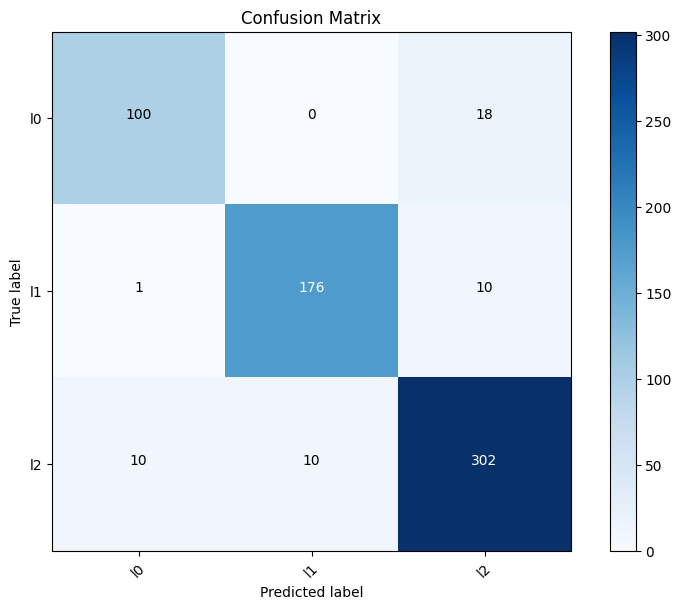

In [4]:

# Evaluate the model
results = model_vit.evaluate(test_gen)
print('Test loss and accuracy: ', results)

# Make predictions
predictions = model_vit.predict(test_gen)
rounded_pred = np.argmax(predictions, axis=-1)

# Confusion Matrix
cm = confusion_matrix(y_true=test_gen.classes, y_pred=rounded_pred)
cm_plot_labels = ['l0', 'l1', 'l2']

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Classification Report
print(classification_report(y_true=test_gen.classes, y_pred=rounded_pred, target_names=cm_plot_labels))

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import numpy as np

# Assuming you've already run your model on the test set and have predictions
y_pred = model_vit.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['l0', 'l1', 'l2']))

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Calculate per-class metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * precision * recall / (precision + recall)

# Calculate macro-averaged metrics
macro_recall = np.mean(recall)
macro_precision = np.mean(precision)
macro_f1_score = np.mean(f1_score)
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred_classes)
custom_balanced_accuracy = np.mean((recall + specificity) / 2)

# Print class-wise metrics
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Specificity: {specificity[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BAC): {balanced_accuracy:.3f}")
print(f"Custom Balanced Accuracy (BCC): {custom_balanced_accuracy:.3f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step
Classification Report:
              precision    recall  f1-score   support

          l0       0.90      0.85      0.87       118
          l1       0.95      0.94      0.94       187
          l2       0.92      0.94      0.93       322

    accuracy                           0.92       627
   macro avg       0.92      0.91      0.91       627
weighted avg       0.92      0.92      0.92       627

Confusion Matrix:
[[100   0  18]
 [  1 176  10]
 [ 10  10 302]]

Class-wise Metrics:
Class 0:
  TP: 100
  TN: 498
  FP: 11
  FN: 18
  Recall: 0.847
  Specificity: 0.978
  Precision: 0.901
  F1-score: 0.873
Class 1:
  TP: 176
  TN: 430
  FP: 10
  FN: 11
  Recall: 0.941
  Specificity: 0.977
  Precision: 0.946
  F1-score: 0.944
Class 2:
  TP: 302
  TN: 277
  FP: 28
  FN: 20
  Recall: 0.938
  Specificity: 0.908
  Precision: 0.915
  F1-score: 0.926

Macro-averaged Metrics:
Macro Recall: 0.909
Macro Precision: 0.921
Macro F1-score: 0.914
Accuracy (ACC): 0.